In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Notebook Setup

In [2]:
from typing import List, Union, Optional
import lmfit as lm
from dat_analysis import get_dat, get_dats
from dat_analysis.analysis_tools import nrg
from dat_analysis.analysis_tools.general_fitting import calculate_fit, FitInfo
from dat_analysis.useful_functions import mean_data, get_data_index
from dat_analysis.plotting.mpl.util import make_axes, ax_setup
from dat_analysis.plotting.mpl.plots import display_2d, waterfall_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
import numpy as np
import datetime


In [3]:
print(f'Notebook last run on {datetime.date.today()}')

Notebook last run on 2022-03-23


Adjust dpi and figsize to make figure below look like a full size figure with reasonable text size

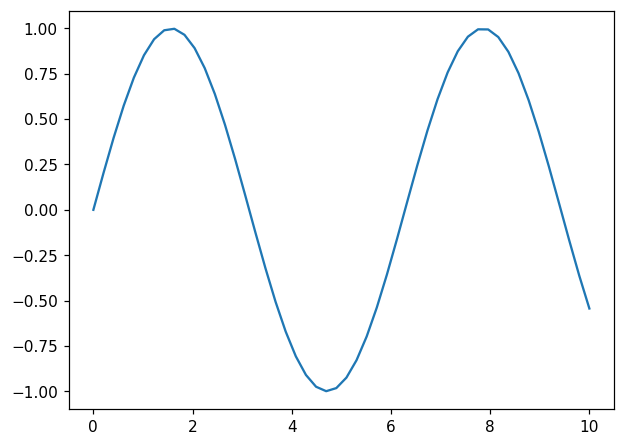

In [4]:
%matplotlib inline
mpl.rcParams.update({
    'figure.figsize': (6.4,4.8),
    'figure.dpi': 110,  # 27in 1440p = 110
})
plt.plot(np.linspace(0,10), np.sin(np.linspace(0,10)))

# Introduction

This document is intended to go through some of the comparisons between experimental data and NRG data provided by Yaakov Kleeoring and Yigal Meir. 

Currently, NRG calculations show a distinct shift of the dN/dT signal towards the occupied state of the QD in the high Gamma limit, however, this is not seen in experiment. 

This document shows a summary of how the data comparison is carried out, and the results of that comparison.


# Loading Data

Experimental data presented in 'Entropy measurement of a strongly correlated quantum dot' are from measurements Feb/March 2021. Measured on what we refer to as Owen's DD (the first two chamber electron heating device that had 2 additional QDs near the entropy sensing QD).

I'll first get the information we are going to use later from each of the HDF files now, and put that into a few containers to keep track of it.

I'm using my functions to load the HDF file only so that I don't have to worry about annoying differences between how data is recorded in different cooldowns (i.e. my library standardizes the interface with measurement data)

In [5]:

@dataclass
class Data:
    datnum: int
    # Recorded data
    original_x: np.ndarray
    y: np.ndarray  # This won't change with processing
    original_i_sense2d: np.ndarray

    # Other recorded attributes
    x_label: str
    y_label: str
    coupling_gate_val: float  # What potential on the coupling gate (i.e. useful for identifying weak/strong coupled data)
    num_samples_per_setpoint: int  # How many datapoints per heating setpoint
    num_steps: int  # Number of full heating cycles (DACs set at the beginning of each cycle)
    measurement_frequency_hz: float  # Rate of datapoint measurement

    # Variables required for processing
    center_before_averaging: bool   # Whether to center the data with individual transition fits to unheated data before averaging
    fitting_width_mv: float  # How much data on either side of zero to use for fitting (in units of sweep gate)
    setpoint_averaging_delay: float = 0.01  # how many seconds of data to throw out after each setpoint change
    forced_theta: Optional[float] = None  # Forced theta value for fitting (necessary for gamma broadened)
    forced_gamma: Optional[float] = 0.001  # Forced gamma value for fitting (necessary for thermally broadened)

    # Calculated things
    centers: List[float] = None  # Center positions of each row of data (only for weakly coupled data)
    cold_fit: FitInfo = None  # Result from fitting averaged unheated i_sense
    hot_fit: FitInfo = None  # Result from fitting averaged heated i_sense

    # Calculated data
    x: np.ndarray = None  # x_array with num_steps shape (i.e. one x val per DAC step)
    i_sense_separated: np.ndarray = None  # I_sense data separated into each part of heating square wave (after averaging setpoints)
    i_sense_cold: np.ndarray = None  # Average together the unheated parts of data
    i_sense_hot: np.ndarray = None   # Average together the heated parts of data
    entropy_signal: np.ndarray = None  # Average heated minus average unheated i_sense  (2D entropy signal)
    avg_x: np.ndarray = None  # x_array centered around 0 after averaging data (i.e. if centering data anyway, might as well define 0 as center)
    average_i_sense: np.ndarray = None  # Averaged i_sense using center values to align first
    average_i_sense_std: np.ndarray = None  # stdev of i_sense data averaged
    average_i_sense_cold: np.ndarray = None # Average together the unheated parts of data
    average_i_sense_hot: np.ndarray = None  # Average together the heated parts of data
    average_entropy_signal: np.ndarray = None  # Averaged entropy using center values to align first
    average_entropy_signal_std: np.ndarray = None  # stdev of entropy data averaged


dats = get_dats([2164, 2121, 2167, 2133], exp2hdf='febmar21tim')
fit_widths = [50, 100, 200, 400]
datas = []
for dat, fit_width in zip(dats, fit_widths):
    data = Data(
        datnum=dat.datnum,
        original_x=dat.Data.x_array,
        y=dat.Data.y_array,
        original_i_sense2d=dat.Data.i_sense,
        x_label = dat.Logs.xlabel,
        y_label = dat.Logs.ylabel,
        coupling_gate_val=dat.Logs.dacs['ESC'],
        num_samples_per_setpoint=int(dat.Logs.awg.wave_len/4),
        num_steps=dat.Logs.awg.num_steps,
        measurement_frequency_hz=dat.Logs.measure_freq,
        center_before_averaging=True if dat.Logs.dacs['ESC'] < -225 else False,
        fitting_width_mv=fit_width,
    )
    datas.append(data)


I'll just plot the recorded data in a few different ways first to give a reasonable idea of what the measurements look like

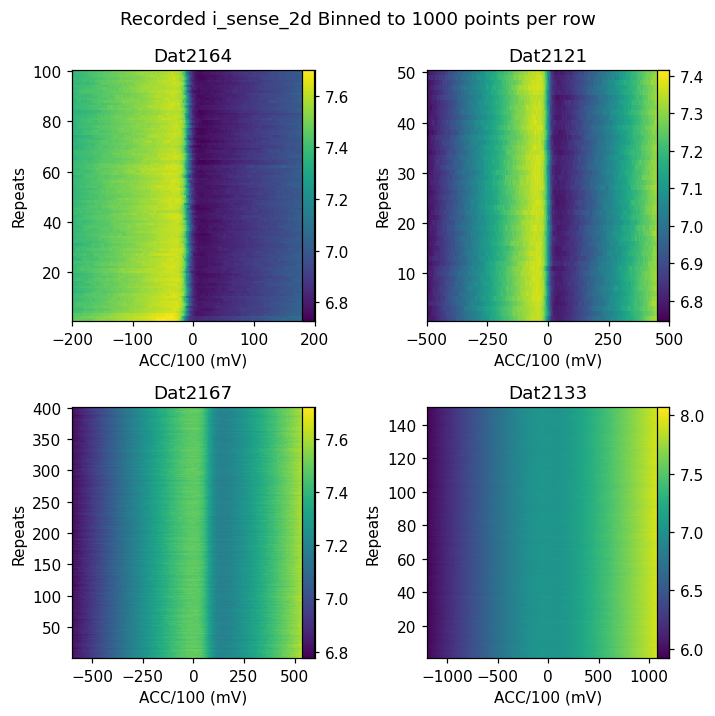

In [6]:
fig, axs = make_axes(len(datas))

for data, ax in zip(datas, axs):
    ax = display_2d(
        data.original_x, data.y, data.original_i_sense2d,
        ax=ax, colorscale=True,
        x_label=data.x_label, y_label=data.y_label,
        auto_bin=True
               )
    ax.set_title(f'Dat{data.datnum}')
fig.suptitle('Recorded i_sense_2d Binned to 1000 points per row')
fig.tight_layout()

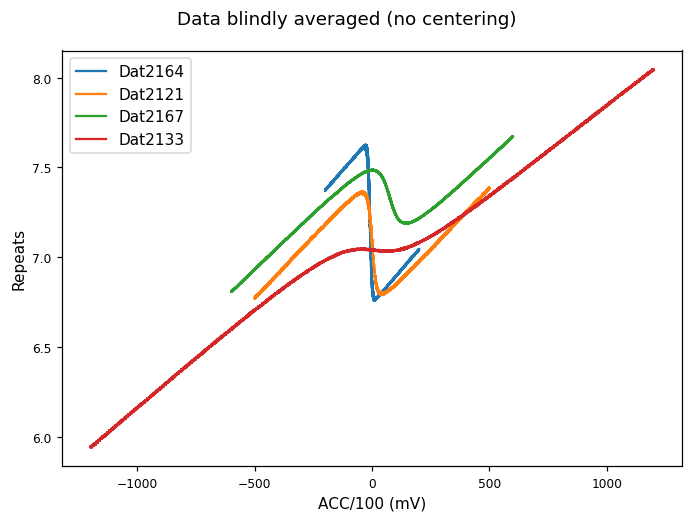

In [7]:
fig, ax = plt.subplots(1)

for data in datas:
    ax.plot(data.original_x, np.mean(data.original_i_sense2d, axis=0), label=f'Dat{data.datnum}')

ax_setup(ax, x_label=datas[0].x_label, y_label=datas[0].y_label)
ax.legend()
fig.suptitle('Data blindly averaged (no centering)')
fig.tight_layout()

## Standard processing of square wave heated data
Need to:
 - separate out the recorded data into the different heating sections
 - average the data from each setpoint (excluding a settling time)
 - average together the heated/unheated parts and generate entropy signal
 - fit the unheated parts (to obtain center values. Only necessary for not very gamma broadened data)
 - average 2D to 1D data using centers (where calculated, otherwise just blindly average)

### Separate into heating sections AND average data from each setpoint

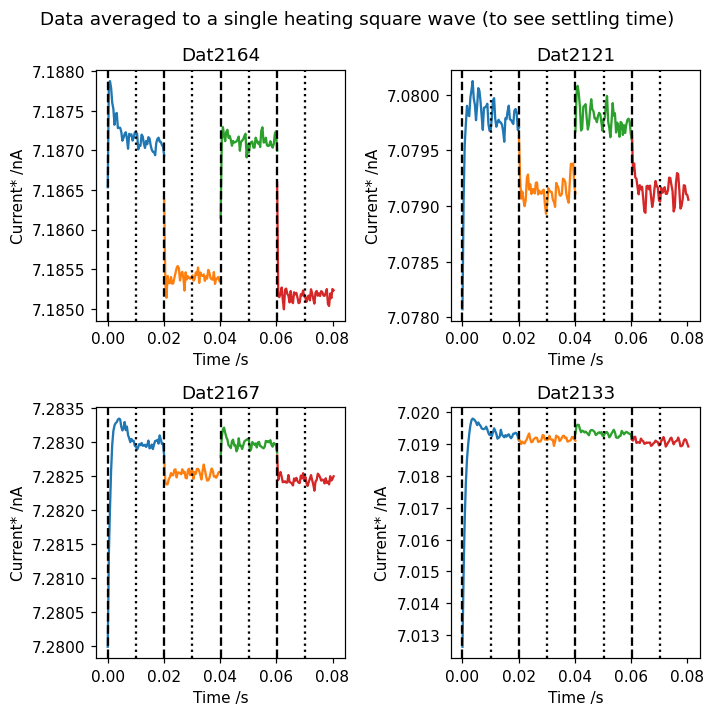

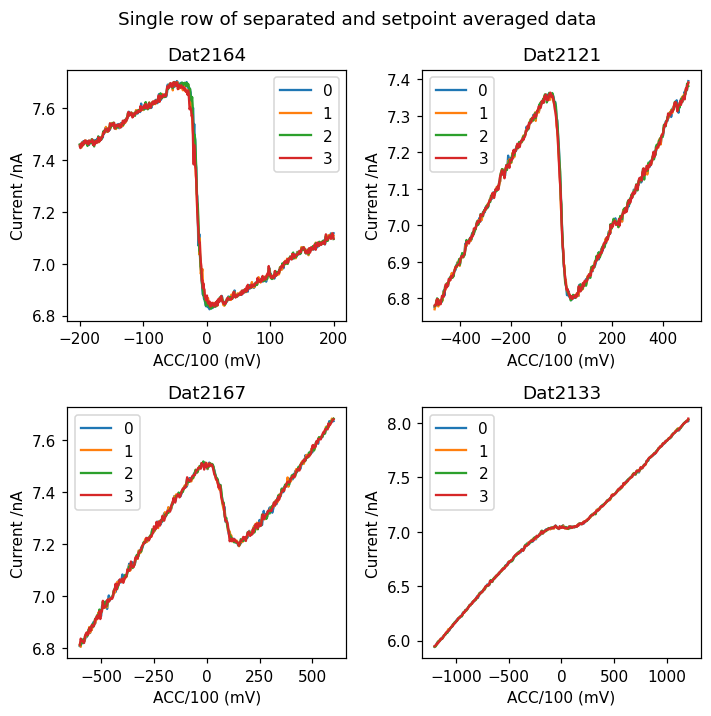

In [8]:
fig1, axs1 = make_axes(len(datas))
fig1.suptitle(f'Data averaged to a single heating square wave (to see settling time)')
for ax in axs1:
    ax.set_xlabel('Time /s')
    ax.set_ylabel('Current* /nA')

fig2, axs2 = make_axes(len(datas))
fig2.suptitle(f'Single row of separated and setpoint averaged data')
for ax in axs2:
    ax.set_ylabel('Current /nA')


for data, ax1, ax2 in zip(datas, axs1, axs2):
    ax1.set_title(f'Dat{data.datnum}')
    ax2.set_title(f'Dat{data.datnum}')
    ax2.set_xlabel(data.x_label)

    # Separate by setpoint
    delay_index = round(data.setpoint_averaging_delay*data.measurement_frequency_hz)
    data_by_setpoint = data.original_i_sense2d.reshape((data.original_i_sense2d.shape[0], -1, 4, data.num_samples_per_setpoint))
                                                                    # (repeats, steps, 4 sections, samples)

    # Plot the square waves averaged on top of each other
    setpoint_duration = data.num_samples_per_setpoint/data.measurement_frequency_hz
    for i in range(4):
        startx = 0 + i*setpoint_duration
        endx = startx + setpoint_duration
        averaged_to_single_setpoint = np.mean(data_by_setpoint[:,:,i,:], axis=(0,1))
        ax1.plot(np.linspace(startx, endx, data.num_samples_per_setpoint), averaged_to_single_setpoint, label=i)
        ax1.axvline(startx+data.setpoint_averaging_delay, linestyle=':', color='k')
        ax1.axvline(startx, linestyle='--', color='k')

    # Average parts of setpoint after delay
    data.i_sense_separated = np.mean(data_by_setpoint[:, :, :, delay_index:], axis=-1)
    data.x = np.linspace(data.original_x[0], data.original_x[-1], data.num_steps)

    for i in range(4):
        ax2.plot(data.x, data.i_sense_separated[0, :, i], label=i)  # Plotting row 0 of each data
    ax2.legend()


    # Calculate E

for fig in fig1, fig2:
    fig.tight_layout()

The first set of figures here show the averaged heating square waves (i.e. every heating square wave from the entired dataset averaged on top of each other), where the dashed line indicates heating changes, and the dotted line indicates the point at which we will start averaging the data (i.e. throwing out data before the dotted lines).
This is to determine how much data has to be ignored before averaging the setpoints (mostly determined by the first section which occurs after DAC steps)

The second set of graphs shows a single sweep of the data separated into the 4 parts of the square wave. In the weakly coupled regime you can see the difference between heated and unheated

### Average together heated/unheated parts and generate entropy signal

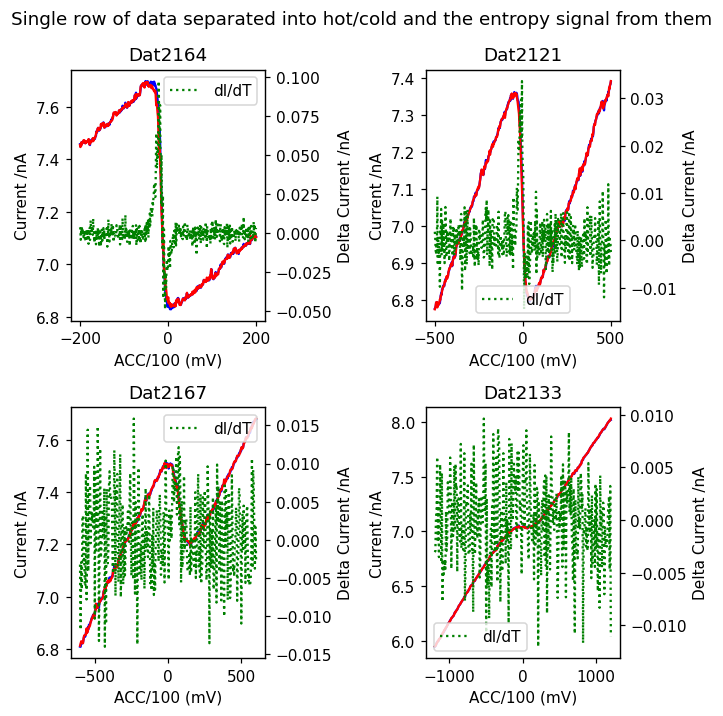

In [9]:
fig, axs = make_axes(len(datas))
fig.suptitle(f'Single row of data separated into hot/cold and the entropy signal from them')
for ax in axs:
    ax.set_ylabel('Current /nA')

for data, ax in zip(datas, axs):
    ax.set_title(f'Dat{data.datnum}')
    ax.set_xlabel(data.x_label)

    data.i_sense_cold = np.mean(data.i_sense_separated[:,:,(0,2)], axis=-1)
    data.i_sense_hot = np.mean(data.i_sense_separated[:,:,(1,3)], axis=-1)
    data.entropy_signal = data.i_sense_cold - data.i_sense_hot

    ax.plot(data.x, data.i_sense_cold[0], 'b-')
    ax.plot(data.x, data.i_sense_hot[0], 'r-')

    ax2 = ax.twinx()
    ax2.plot(data.x, data.entropy_signal[0], 'g:', label='dI/dT')
    ax2.set_ylabel('Delta Current /nA')
    ax2.legend()
fig.tight_layout()


Since this is only a single row of data, for the high Gamma measurements, the signal to noise is extremely weak. After averaging we'll see more.

I'll quickly plot the 2D entropy signal which does show something

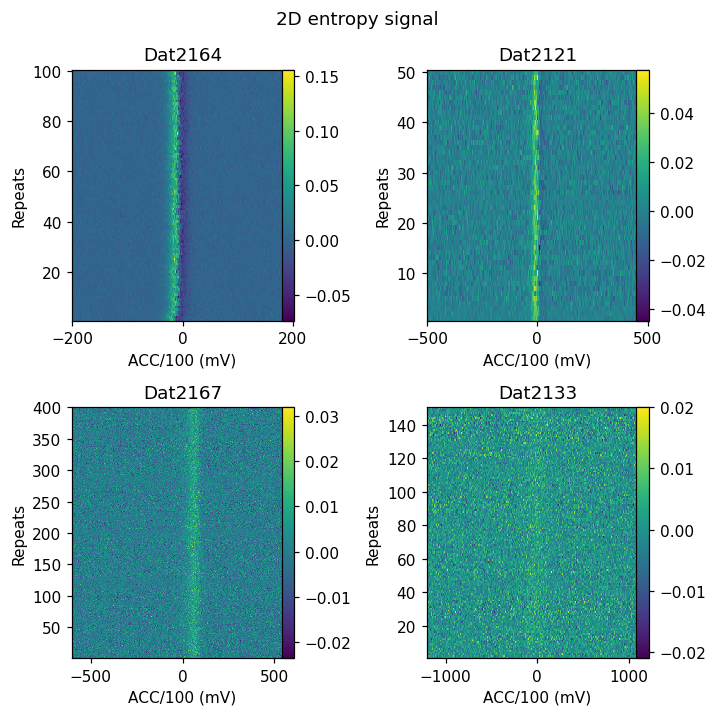

In [10]:
fig, axs = make_axes(len(datas))
fig.suptitle(f'2D entropy signal')

for data, ax in zip(datas, axs):
    display_2d(data.x, data.y, data.entropy_signal, ax, x_label=data.x_label, y_label=data.y_label, colorscale=True)
    ax.set_title(f'Dat{data.datnum}')

fig.tight_layout()

Can see that there is a dI/dT signal even at higher Gamma

### Fit unheated parts to obtain centers for averaging

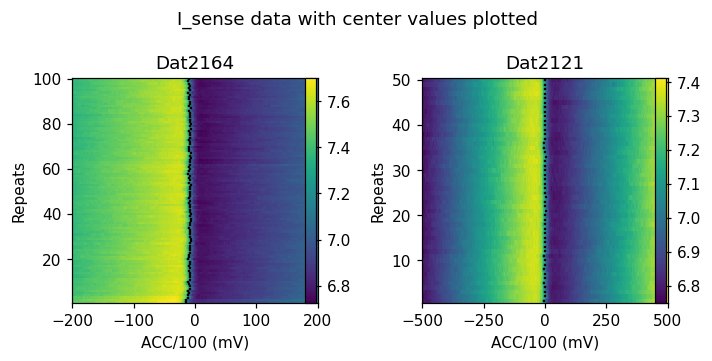

In [11]:
def weak_transition_func(x, mid, theta, amp, lin, const):
    """Charge transition shape for weak coupling only"""
    arg = (x - mid) / (2 * theta)
    return -amp / 2 * np.tanh(arg) + lin * (x - mid) + const

fig, axs = make_axes(sum([data.center_before_averaging for data in datas]))
fig.suptitle('I_sense data with center values plotted')
i = 0
for data in datas:
    if data.center_before_averaging:
        ax = axs[i]
        i+=1
        ax.set_title(f'Dat{data.datnum}')
        d = data.i_sense_cold
        x = data.x
        params = lm.Parameters()
        params.add_many(
            # param, value, vary, min, max
            lm.Parameter('mid', np.mean(x), True, np.min(x), np.max(x)),
            lm.Parameter('amp', np.max(d)-np.min(d), True, 0, 2),
            lm.Parameter('const', np.mean(d), True),
            lm.Parameter('lin', 0, True, 0, 0.01),
            lm.Parameter('theta', 10, True, 0, 100),
        )
        fits = [calculate_fit(x, d1d, params, weak_transition_func, method='leastsq') for d1d in d]   # basically wraps model.fit from lmfit
        data.centers = [fit.best_values.mid for fit in fits]

        display_2d(x, data.y, d, ax, colorscale=True, x_label=data.x_label, y_label=data.y_label)
        ax.scatter(data.centers, data.y, s=2, c='k', marker='+')
    else:
        data.centers = np.zeros(data.y.shape[0])
fig.tight_layout()


Graphs above are to check that the fitting of each individual row of unheated data has done a good job of finding a reasonable center point that will be used for averaging

### Average 2D to 1D using centers calculated

In [12]:
for data in datas:
    # Average Transition Data
    averaged_datas = []
    for i in range(4):
        averaged_datas.append(
            mean_data(data.x, data.i_sense_separated[:,:,i],
                      centers=data.centers, return_x=True, return_std=True, nan_policy='omit')
        )
        # Note: mean_data returns [avg_data, centered_x_array, stdev of data averaged]
    data.average_i_sense = np.array([d[0] for d in averaged_datas])
    assert np.all(np.all([averaged_datas[0][1] == averaged_datas[i][1] for i in range(3)]))  # Ensure the x_arrays returned are all identical to each other
    data.avg_x = averaged_datas[0][1]
    data.average_i_sense = np.array([d[0] for d in averaged_datas])
    data.average_i_sense_std = np.array([d[2] for d in averaged_datas])
    data.average_i_sense_cold = np.mean(data.average_i_sense[(0,2), :], axis=0)
    data.average_i_sense_hot = np.mean(data.average_i_sense[(1,3), :], axis=0)

    # Average Entropy Data
    data.average_entropy_signal, x_, data.average_entropy_signal_std = mean_data(data.x, data.entropy_signal,
                      centers=data.centers, return_x=True, return_std=True, nan_policy='omit')
    # Note: mean_data returns [avg_data, centered_x_array, stdev of data averaged]
    assert np.all(data.avg_x == x_)  # Ensure same x_axis for entropy data


I'm using my own `mean_data` function here, effectively what it is doing is centering the data first using the center values provided, then averaging along axis 0.
To do the centering requires some interpolation to end up with the same x_axis for each row of data before averaging, so that's why I'm not showing it all in the cell here.
`mean_data` returns three things:
- the averaged data
- the new centered x_array for that data
- the standard deviation of all the values averaged together for each datapoint. (Note that it is the standard deviation, **NOT** the standard error. To convert to standard error it should be divided by $\sqrt{N}$ where $N$ is the number of repeats (shape of `data.y`)

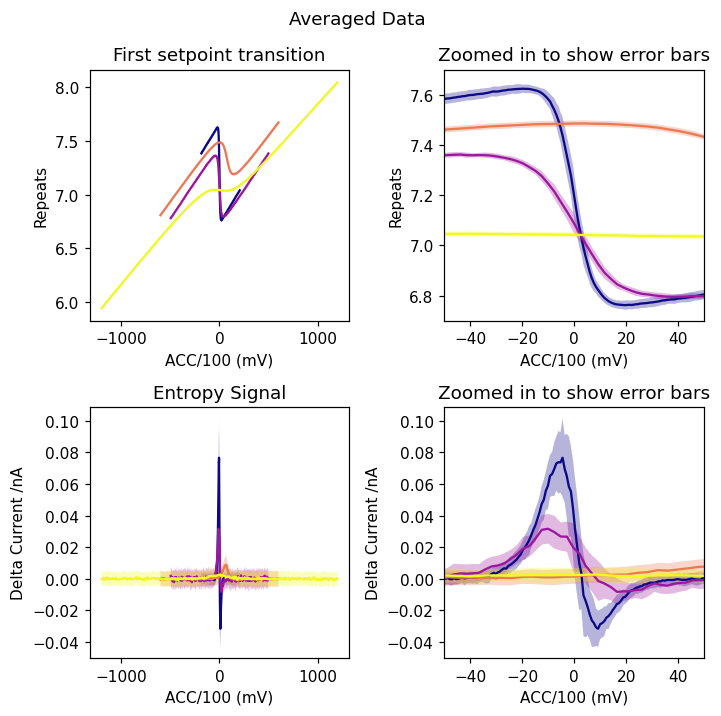

In [13]:
fig, axs = make_axes(len(datas))
fig.suptitle(f'Averaged Data')
transition_axs = axs[0:2]
entropy_axs = axs[2:]

colors = plt.get_cmap('plasma')(np.linspace(0, 1, len(datas)))

for ax in transition_axs:  # Plot exactly the same thing twice
    for data, c in zip(datas, colors):
        d, std = data.average_i_sense[0], data.average_i_sense_std[0] # /np.sqrt(data.y.shape[0])
        ax.plot(data.avg_x, d, c=c, label=f'Dat{data.datnum}')
        ax.fill_between(data.avg_x, d-std, d+std, facecolor=c, alpha=0.3)
    ax.set_ylabel(datas[0].y_label)
# Zoom in on one of the plots
transition_axs[0].set_title(f'First setpoint transition')
transition_axs[1].set_title(f'Zoomed in to show error bars')
transition_axs[1].set_xlim(-50, 50)
transition_axs[1].set_ylim(6.7, 7.7)

for ax in entropy_axs:  # Plot exactly the same thing twice
    for data, c in zip(datas, colors):
        d, std = data.average_entropy_signal, data.average_entropy_signal_std # /np.sqrt(data.y.shape[0])
        ax.plot(data.avg_x, d, c=c, label=f'Dat{data.datnum}')
        ax.fill_between(data.avg_x, d-std, d+std, facecolor=c, alpha=0.3)
    ax.set_ylabel('Delta Current /nA')
# Zoom in on one of the plots
entropy_axs[0].set_title(f'Entropy Signal')
entropy_axs[1].set_title(f'Zoomed in to show error bars')
entropy_axs[1].set_xlim(-50, 50)
# entropy_axs[1].set_ylim(6.7, 7.7)

for ax in axs:
    ax.set_xlabel(datas[0].x_label)



fig.tight_layout()


This is the data averaged after centering (for the more weakly coupled data), where the standard deviation, $\sigma$, of all data averaged together is plotted. Note that this is **NOT** the standard error ($\sigma/\sqrt{N}$).
Although it should make more sense to plot standard error, in practice the error bars end up invisibly small, and realistically, there is a significant uncertainty in these measurements. At the same time, the pure standard deviation is too large of an error bar. So this is really just for guidance as to how the data looks, and the **error bars should not be taken seriously**.

# Fitting to NRG

For details on how I work with NRG data, see the `202203_nrg_fitting_explained.pdf`.

When fitting data to NRG, I can only vary one of `theta` or `gamma` at a time as they are too closely correlated otherwise, and I end up getting very unreliable results.
Because of that, it is necessary to first figure out what `theta` should be for the gamma broadened measurements.

As a first approximation, we can just use the `theta` we find for the weakly coupled data where `gamma = 0`. That is what I will plot initially, as it may be insightful enough.

The assumption that `theta` remains constant does not take into account the change in lever arm strength of the plunger gate as a function of the coupling gate. I.e. as the coupling gate is made more positive to open up the QD to the reservoir, this also has the effect of making the plunger gate (`ACC`) less effective at changing dot occupation.

Additionally, the charge sensor does not quite have a linear response, and so for the very broadened measurements, this plays a larger role. Again, we will first ignore this and only include it later if necessary





## Fitting weakly coupled

Dat2164 Fit values:
	Unheated Theta: 3.925±0.006 mV
	Heated Theta: 4.910±0.007 mV
	Delta Theta: 0.985 mV



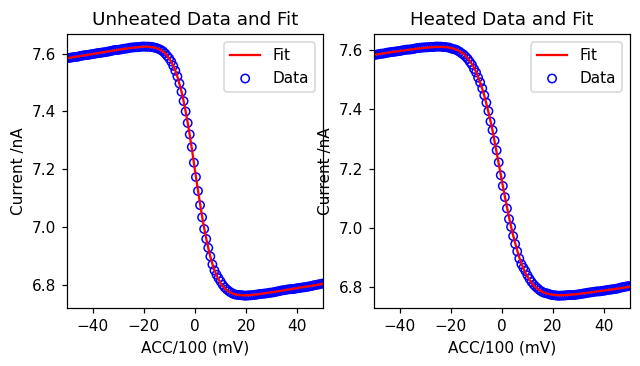

In [14]:
weak_datas = datas[0:1]  # Currently, only first dataset is weakly coupled
fig, axs = make_axes(len(weak_datas)*2)

nrg_helper = nrg.NrgUtil()
for i, data in enumerate(weak_datas):
    # initial guess for params
    params = lm.Parameters()
    params.add_many(
        # name, value, vary, min, max
        lm.Parameter('mid', 0, True),
        lm.Parameter('amp', 1, True, 0, 2),
        lm.Parameter('const', 7, True),
        lm.Parameter('lin', 0.0001, True, 0, 0.01),
        lm.Parameter('theta', 10, True, 0, 50),
        lm.Parameter('g', 0.001, False),  # NOT varying g while fitting
        lm.Parameter('occ_lin', 0, False),  # Not usually necessary to vary this
    )
    x, d_c, d_h = data.avg_x, data.average_i_sense_cold, data.average_i_sense_hot
    indexes = get_data_index(x, [-data.fitting_width_mv, data.fitting_width_mv])
    s = np.s_[indexes[0]:indexes[1]]
    x, d_c, d_h = x[s], d_c[s], d_h[s]
    data.cold_fit = nrg_helper.get_fit(x, d_c, initial_params=params, which_data='i_sense')
    data.hot_fit = nrg_helper.get_fit(x, d_h, initial_params=params, which_data='i_sense')

    print(f'Dat{data.datnum} Fit values:\n'
          f'\tUnheated Theta: {data.cold_fit.best_values.theta:.3f}\u00b1{data.cold_fit.params["theta"].stderr:.3f} mV\n'
          f'\tHeated Theta: {data.hot_fit.best_values.theta:.3f}\u00b1{data.hot_fit.params["theta"].stderr:.3f} mV\n'
          f'\tDelta Theta: {data.hot_fit.best_values.theta - data.cold_fit.best_values.theta:.3f} mV\n'
          )

    for ax, d, fit in zip(axs[i*2:i*2+2], [data.average_i_sense_cold, data.average_i_sense_hot], [data.cold_fit, data.hot_fit]):
        ax.scatter(data.avg_x, d, label='Data', s=30, marker='o', facecolors='none', edgecolors='b')
        ax.plot(data.avg_x, fit.eval_fit(x=data.avg_x), label='Fit', c='r')
        ax.set_xlabel(data.x_label)
        ax.set_ylabel('Current /nA')
        ax.set_xlim(-50, 50)
        ax.legend()
    axs[2*i].set_title('Unheated Data and Fit')
    axs[2*i+1].set_title('Heated Data and Fit')


Calculated fits to both heated and unheated data.

In [15]:
cold_theta = datas[0].cold_fit.best_values.theta
hot_theta = datas[0].hot_fit.best_values.theta
delta_theta = hot_theta-cold_theta


## Fitting Strongly Coupled

For now we will assume the thetas from weak coupling can be used in strong coupling without any adjustment (an OK approximation)


Dat2121 Fit values:
	Unheated Gamma: 6.173±0.091 mV
	Heated Gamma: 6.971±0.097 mV
	Gamma Error: 12.142 % error

Dat2167 Fit values:
	Unheated Gamma: 24.448±0.195 mV
	Heated Gamma: 25.124±0.179 mV
	Gamma Error: 2.729 % error

Dat2133 Fit values:
	Unheated Gamma: 77.132±1.263 mV
	Heated Gamma: 77.920±0.916 mV
	Gamma Error: 1.016 % error



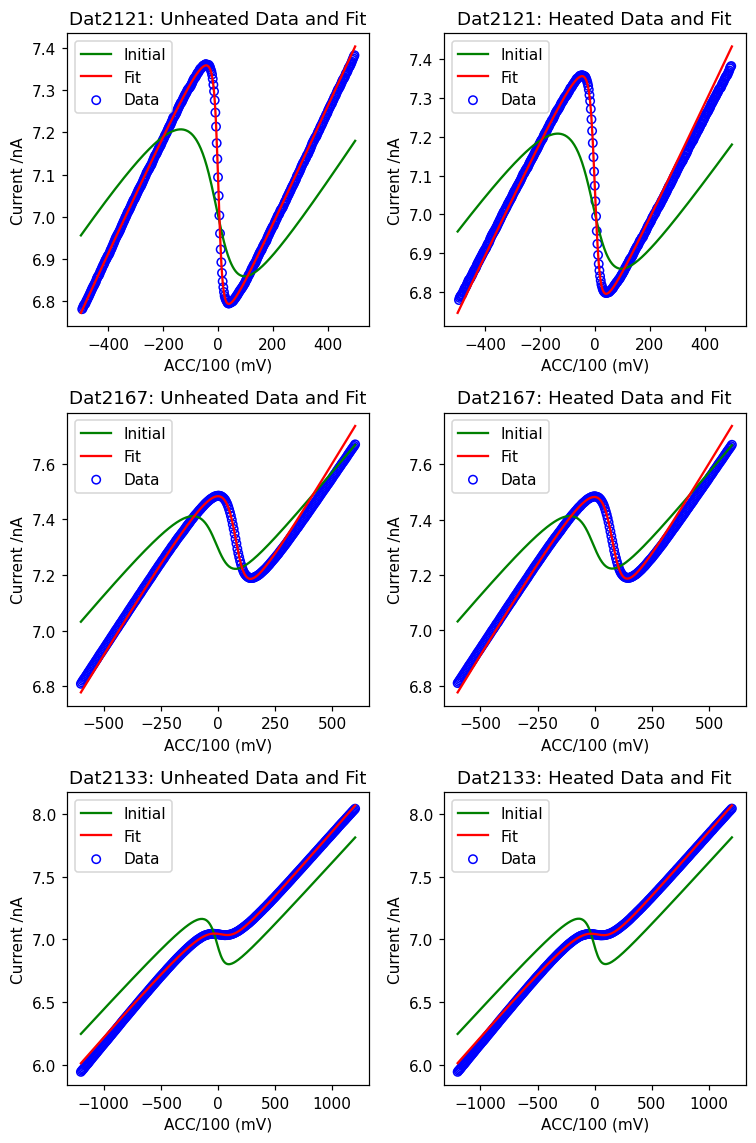

In [16]:
strong_datas = datas[1:]
fig, axs = plt.subplots(len(strong_datas), 2, figsize=(7, 3.5*len(strong_datas)))
axs = axs.flatten()

nrg_helper = nrg.NrgUtil()
for i, data in enumerate(strong_datas):

    # Only use data near transition
    x, d_c, d_h = data.avg_x, data.average_i_sense_cold, data.average_i_sense_hot
    indexes = get_data_index(x, [-data.fitting_width_mv, data.fitting_width_mv])
    s = np.s_[indexes[0]:indexes[1]]
    x, d_c, d_h = x[s], d_c[s], d_h[s]

    # initial guess for params
    params = lm.Parameters()
    params.add_many(
        # name, value, vary, min, max
        lm.Parameter('mid', np.mean(x), True, np.min(x), np.max(x)),
        lm.Parameter('amp', np.nanmax(d)-np.nanmin(d), True, 0.1, 1),
        lm.Parameter('const', np.nanmean(d_c), True),
        lm.Parameter('lin', 0.001, True, 0, 0.005),
        lm.Parameter('theta', cold_theta, False),  # Don't vary theta for Strong coupling fitting
        lm.Parameter('g', 40, True, cold_theta/1000, cold_theta*50),
        lm.Parameter('occ_lin', 0, False),  # Not usually necessary to vary this
    )

    # Fit Cold
    data.cold_fit = nrg_helper.get_fit(x, d_c, initial_params=params, which_data='i_sense')

    # Force hot theta then fit hot
    params['theta'].value = hot_theta
    data.hot_fit = nrg_helper.get_fit(x, d_h, initial_params=params, which_data='i_sense')

    cold_g, hot_g = data.cold_fit.best_values.g, data.hot_fit.best_values.g

    print(f'Dat{data.datnum} Fit values:\n'
          f'\tUnheated Gamma: {cold_g:.3f}\u00b1{data.cold_fit.params["g"].stderr:.3f} mV\n'
          f'\tHeated Gamma: {hot_g:.3f}\u00b1{data.hot_fit.params["g"].stderr:.3f} mV\n'
          f'\tGamma Error: {abs(hot_g-cold_g)/(np.mean([hot_g, cold_g]))*100:.3f} % error\n'
          )

    for ax, d, fit in zip(axs[i*2:i*2+2], [data.average_i_sense_cold, data.average_i_sense_hot], [data.cold_fit, data.hot_fit]):
        ax.scatter(data.avg_x, d, label='Data', s=30, marker='o', facecolors='none', edgecolors='b')
        ax.plot(data.avg_x, fit.eval_init(x=data.avg_x), label='Initial', c='g')
        ax.plot(data.avg_x, fit.eval_fit(x=data.avg_x), label='Fit', c='r')
        ax.set_xlabel(data.x_label)
        ax.set_ylabel('Current /nA')
        ax.legend()
    axs[2*i].set_title(f'Dat{data.datnum}: Unheated Data and Fit')
    axs[2*i+1].set_title(f'Dat{data.datnum}: Heated Data and Fit')

fig.tight_layout()

Getting NRG data to fit is a bit more finicky, so it's helpful to see what the initial guesses are. They need to be quite close in order for fitting to work.

Overall, we see that we have quite good fits (i.e. gamma calculated from unheated/heated are pretty similar, line seems to follow well near the middle of the transition - where we are fitting).

We can now use these fit parameters to compare the dNdT to NRG

# Comparison of Data to NRG

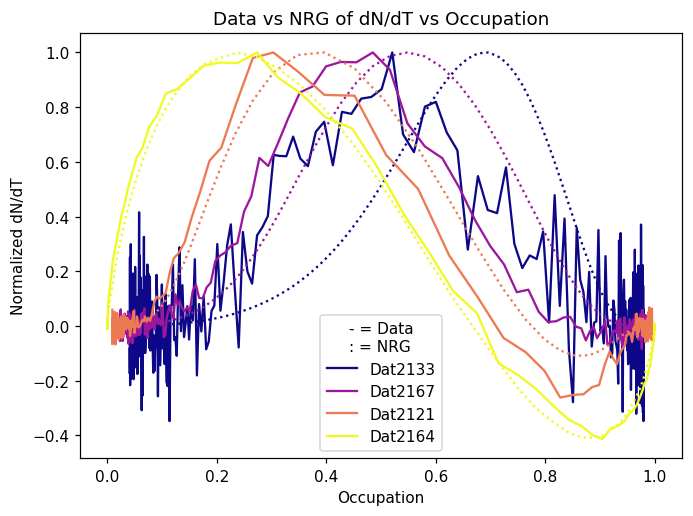

In [17]:
fig, ax = plt.subplots(1)

colors = plt.get_cmap('plasma')(np.linspace(0, 1, len(datas)))

nrg_helper = nrg.NrgUtil()
for data, c in (zip(reversed(datas), colors)):
    cold_values, hot_values = data.cold_fit.best_values, data.hot_fit.best_values
    nrg_helper.init_params(
        mid = np.mean([hot_values.mid, cold_values.mid]),
        amp = np.mean([hot_values.amp, cold_values.amp]),
        const = np.mean([hot_values.const, cold_values.const]),
        lin = np.mean([hot_values.lin, cold_values.lin]),
        theta = np.mean([hot_values.theta, cold_values.theta]),
        g = np.mean([hot_values.g, cold_values.g]),
        occ_lin = np.mean([hot_values.occ_lin, cold_values.occ_lin]),
    )
    nrg_dndt = nrg_helper.data_from_params(x=data.avg_x, which_data='dndt', which_x='occupation')
    # Note: This returns both data and x in a Data1D object

    # Normalize both NRG and Data entropy signal to have max of 1
    data_dndt = data.average_entropy_signal/np.nanmax(data.average_entropy_signal)
    nrg_dndt.data = nrg_dndt.data/np.nanmax(nrg_dndt.data)

    ax.plot(nrg_dndt.x, data_dndt, c=c, linestyle='-', label=f'Dat{data.datnum}')
    ax.plot(nrg_dndt.x, nrg_dndt.data, c=c, linestyle=':')

ax.legend(title='- = Data\n: = NRG')
ax.set_xlabel('Occupation')
ax.set_ylabel('Normalized dN/dT')
ax.set_title(f'Data vs NRG of dN/dT vs Occupation')
fig.tight_layout()


Using the average fitting parameters of the heated/unheated data to generate the NRG data. Plotting both against occupation.

We see good agreement in the weakly coupled data, but not for any of the more strongly coupled data. 

# Determining dN/dT differently with NRG

The dN/dT data in the current NRG calculations is calculated by running simulations with two different Ts, where one is ~1% larger, and then subtracting the difference in N between them. I have the data for on fixed T only.

Assuming that the data is only scaled by the ratio T/G and not specific values of each, I should be able to reproduce the same data by comparing the data with varying G and stretching the x-axis appropriately (i.e. what I do in my interpolation of NRG data anyway). Below we will look at that

Then I can generate dN/dT with the change in T being ~30% == 30 mK to match experiment and see if that makes any significant difference to the predicted dN/dT signal


## Varying G and stretch x-axis accordingly

### Can't use my interpolator
My interpolator does treat Theta and Gamma in a way in which I can effectively change either independently (assuming that T/G is the only thing that scales the NRG data). However, I also shift the data so that N=0.5 is roughly at the center just for ease of fitting (otherwise the `mid` parameter is very difficult to estimate)

Because of this, it is definitely wrong to subtract `N` for one T from another as produced by my interpolating function. 

Below I demonstrate this problem


In [18]:
cold_theta = 1.0
hot_theta = 1.30

cold_gamma_over_t_ratios = [0.001, 1, 10, 30]  
x = np.linspace(-200, 200, 500)

mid = 0
amp = 1
const = 0
lin = 0
occ_lin = 0


nrg_helper = nrg.NrgUtil()
nrg_Ns = {}
for gt in cold_gamma_over_t_ratios:
    nrg_Ns[gt] = []
    g = gt*cold_theta
    for theta in (cold_theta, hot_theta):
        nrg_helper.init_params(
            mid = mid,
            amp = amp,
            const = const,
            lin = lin,
            occ_lin = occ_lin,
            theta = theta,
            g = g,
        )
        nrg_N = nrg_helper.data_from_params(x=x, which_data='occupation', which_x='sweepgate')
        nrg_Ns[gt].append(nrg_N)


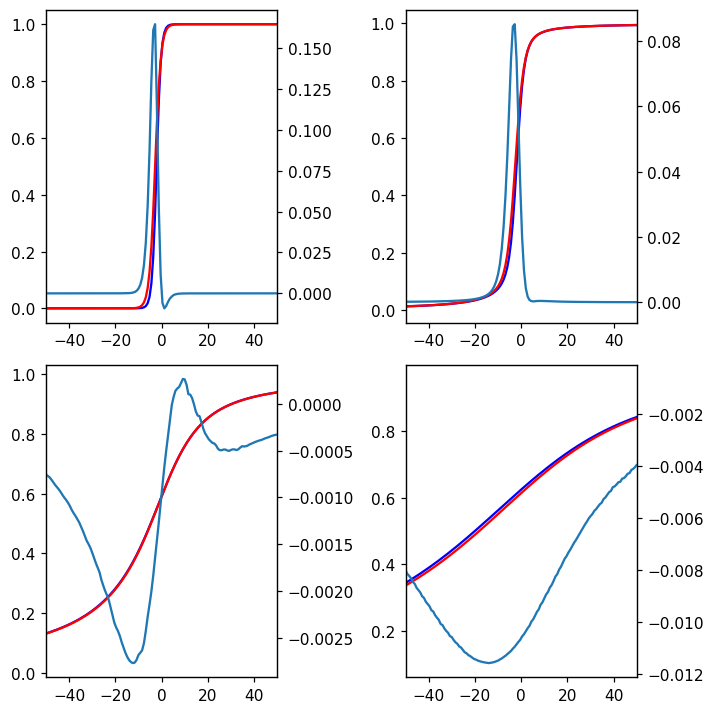

In [19]:
fig, axs = make_axes(len(nrg_Ns))

for gt, ax in zip(nrg_Ns, axs):
    cold_N, hot_N = nrg_Ns[gt]
    ax.plot(cold_N.x, cold_N.data, color='b')
    ax.plot(hot_N.x, hot_N.data, color='r')
    
    ax2 = ax.twinx()
    ax2.plot(cold_N.x, hot_N.data-cold_N.data)
    
    ax.set_xlim(-50, 50)
    
fig.tight_layout()

Clearly, even the weakly coupled data doesn't produce the right dN/dT at all. I think this is a result of my interpolator also shifting the data to be close to `N = 0.5` at `x = 0`. Because this shift is different for each G/T, it doesn't make sense to generate dN/dT from this.


## Can't use NRG with single T

Even if I'm more careful to use the NRG ens (without the arbitrary shift), I still do not have sufficient information to be able to calculate dN/dT using only NRG with T = 0.0001. 

Since the dN/dT comes from the exact shift of the transition due to dS/dT, naively stretching the x-axis to account for different temperatures is not going to give the correct shift due to dS/dT, so there is no reason I should get a reasonable dN/dT in the end. 

This is what the analysis looks like anyway

NRGParams(gamma=0.0013000000000000002, theta=1.0, center=0, amp=1, lin=0, const=0, lin_occ=0)
NRGParams(gamma=0.0013000000000000002, theta=1.3, center=0, amp=1, lin=0, const=0, lin_occ=0)
NRGParams(gamma=1.3, theta=1.0, center=0, amp=1, lin=0, const=0, lin_occ=0)
NRGParams(gamma=1.3, theta=1.3, center=0, amp=1, lin=0, const=0, lin_occ=0)
NRGParams(gamma=13.0, theta=1.0, center=0, amp=1, lin=0, const=0, lin_occ=0)
NRGParams(gamma=13.0, theta=1.3, center=0, amp=1, lin=0, const=0, lin_occ=0)
NRGParams(gamma=39.0, theta=1.0, center=0, amp=1, lin=0, const=0, lin_occ=0)
NRGParams(gamma=39.0, theta=1.3, center=0, amp=1, lin=0, const=0, lin_occ=0)


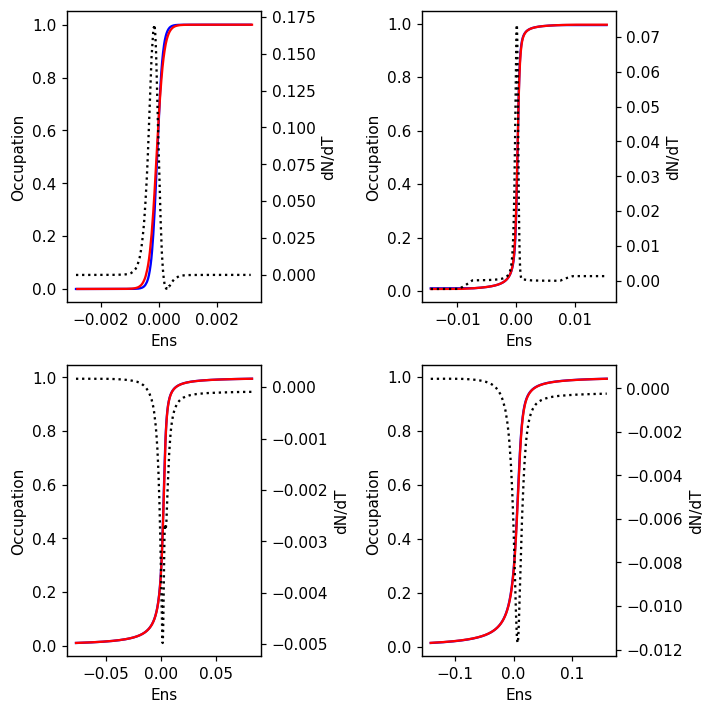

In [37]:
cold_theta = 1.0 
hot_theta = 1.3

gamma_over_t_ratios = [0.001, 1, 10, 30]
xlims = [30, 150, 800, 1500]
# xlims = [v/10000 for v in xlims]

mid = 0
amp = 1
const = 0
lin = 0
occ_lin = 0


nrg_helper = nrg.NrgUtil()
nrg_Ns = {}
for gt, xlim in zip(gamma_over_t_ratios, xlims):
    nrg_Ns[gt] = []
    g = gt*theta
    for theta in (cold_theta, hot_theta):
        x = np.linspace(-xlim, xlim, 1000)
        nrg_helper.init_params(
            mid = mid,
            amp = amp,
            const = const,
            lin = lin,
            occ_lin = occ_lin,
            theta = theta,
            g = g,
        )
        print(nrg_helper.initial_params)
#         nrg_N = nrg_helper.data_from_params(x=x, which_data='occupation', which_x='ens')
        nrg_N = nrg_helper.data_from_params(x=x, which_data='occupation', which_x='ens')
        nrg_N.x = nrg_N.x * theta  # Stretch proportional to Theta
        nrg_Ns[gt].append(nrg_N)
        
fig, axs = make_axes(len(nrg_Ns))
# fig, axs = make_axes(len(nrg_Ns), single_fig_size=(6,6))

for gt, ax in zip(nrg_Ns, axs):
    cold_N, hot_N = nrg_Ns[gt]
    ax.plot(cold_N.x, cold_N.data, color='b')
    ax.plot(hot_N.x, hot_N.data, color='r')
    ax.set_ylabel('Occupation')
    ax.set_xlabel('Ens')
    
    ax2 = ax.twinx()
    dndt = hot_N.data - cold_N.data
    ax2.plot(cold_N.x, dndt, 'k:')
    ax2.set_ylabel('dN/dT')
    
fig.tight_layout()


Definitely still not even close to correct as expected. 